In [2]:
%load_ext version_information

In [3]:
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, astroquery, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2020-07-07 10:39:56 (KST = GMT+0900) 
0 Python     3.7.7 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    7.13.0
2 OS         Darwin 18.7.0 x86_64 i386 64bit
3 scipy      1.4.1
4 numpy      1.18.5
5 matplotlib 3.1.3
6 pandas     1.0.3
7 astroquery 0.4.1.dev6132
8 version_information 1.0.3


In [11]:
from pathlib import Path
import numpy as np
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from astropy import units as u
from astropy.table import vstack
import yssbtmpy as tm

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from accutil import linticker

FIGPATH = Path("figs")

In [5]:
plt.style.use('default')
rcParams.update({'font.size':12})

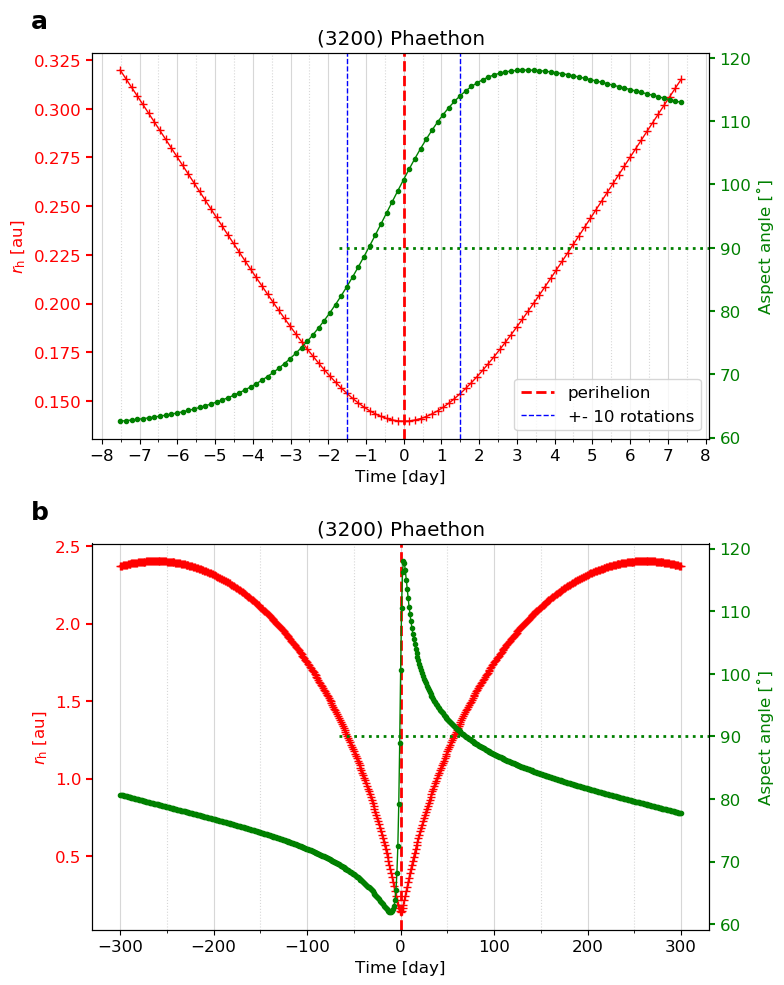

In [19]:
# HanusJ+2018 A&A 620 L8
phys = dict(
    spin_ecl_lon=318*u.deg, spin_ecl_lat=-47*u.deg,
#     spin_ecl_lon=84*u.deg, spin_ecl_lat=-39*u.deg,
    rot_period=3.603957*u.h, p_vis=0.12, slope_par=0.15,
    ti=600*tm.TIU, eta_beam=1, emissivity=0.9,
    mass_den=1670*u.kg/u.m**3, 
    diam_eff=5.1*u.km, 
    diam_eq=5.1*u.km
    )
rot_p_day = phys['rot_period'].to_value('day')

epoch_ref = Time(2456049.8189178086, format='jd')  # perihelion: 2012-05-02T07:39:14.499
epochs_peri = epoch_ref + np.arange(-50*rot_p_day, +50*rot_p_day, rot_p_day) * u.day
epochs_long = dict(start=(epoch_ref - 300.01*u.day).isot, 
                   stop=(epoch_ref + 300.01*u.day).isot, 
                   step='1d')
obj_peri = Horizons(id=3200, epochs=epochs_peri.jd)
eph_peri = obj_peri.ephemerides()
obj_long = Horizons(id=3200, epochs=epochs_long)
eph_long = obj_long.ephemerides()

fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False, sharey=False, gridspec_kw=None)

for i, e in enumerate([eph_peri, eph_long]):
    ax = axs[i]
    # Calculate aspect angles
    pos_ecl = tm.lonlat2cart(lon=e["EclLon"], lat=e["EclLat"])
    spin_ecl = tm.lonlat2cart(lon=phys["spin_ecl_lon"], lat=phys["spin_ecl_lat"])
    e["theta_asp"] = 180 - np.rad2deg(np.arccos(np.inner(pos_ecl.T, spin_ecl)))
    e["objtime_jd"] = Time(e["datetime_jd"], format='jd') - e["lighttime"] # already Quantity
    plotdate = Time(e["objtime_jd"], format='jd').jd - epoch_ref.jd

    _r, = ax.plot(plotdate, e["r"], 'r+-', lw=1)
    ax.axvline(0, color='r', ls='--', lw=2, label="perihelion")
    ax.set(xlabel="Time [day]", 
           ylabel=r"$r_\mathrm{h}$ [au]",
           title="(3200) Phaethon")

    ax2 = ax.twinx()
    _t, = ax2.plot(plotdate, e["theta_asp"], 'g.-', lw=1)
    ax2.axhline(90, xmin=0.4, color='g', ls=':', lw=2)
    ax2.set(ylabel="Aspect angle [˚]")

    # tick and ticklabels color settings:
    ax.yaxis.label.set_color(_r.get_color())
    ax2.yaxis.label.set_color(_t.get_color())

    tkw = dict(size=4, width=1.5)
    ax.tick_params(axis='y', colors=_r.get_color(), **tkw)
    ax2.tick_params(axis='y', colors=_t.get_color(), **tkw)

axs[0].axvline(-10*phys['rot_period'].to_value('day'), color='b', ls='--', lw=1, label="+- 10 rotations")
axs[0].axvline(+10*phys['rot_period'].to_value('day'), color='b', ls='--', lw=1)
axs[0].legend(loc=4)

for i, ax in enumerate(axs.flatten()):
    ax.text(x=-0.10, y=1.05, s=chr(ord('a') + i), transform=ax.transAxes, 
            fontsize=18, fontweight='bold', va='bottom', ha='left')

linticker(axs, xmajlockws=[1, 100], xminlockws=[0.5, 50], ymajgridkws={'ls':''})

plt.tight_layout()

plt.savefig(FIGPATH/"phae_orbit.png", dpi=300, bbox_inches = "tight")
plt.savefig(FIGPATH/"phae_orbit.pdf", bbox_inches = "tight")
plt.show()

eph_all = vstack([eph_peri, eph_long])
eph_all.sort(keys="true_anom")

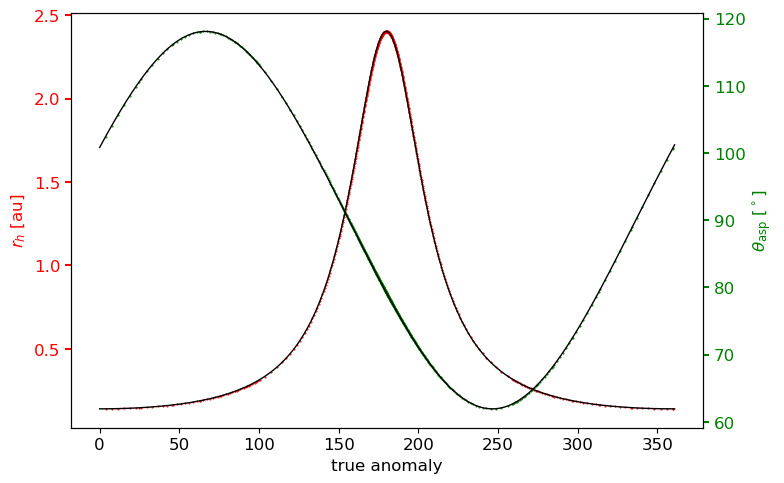

In [20]:
from astropy.table import vstack
from scipy.interpolate import UnivariateSpline

# rh, theta_asp as functions of true anomaly:
spl_rh = UnivariateSpline(eph_all["true_anom"], eph_all["r"], k=3, s=0)
spl_asp = UnivariateSpline(eph_all["true_anom"], eph_all["theta_asp"], k=3, s=0)

xx = np.arange(0, 361, 0.1)
fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)
_r, = axs.plot(eph_all["true_anom"], eph_all["r"], 'r.', ms=1)
axs.plot(xx, spl_rh(xx), 'k-', lw=1)
axs.set(xlabel="true anomaly", ylabel=r"$r_h$ [au]")

ax2 = axs.twinx()
_t, = ax2.plot(eph_all["true_anom"], eph_all["theta_asp"], 'g.', ms=1)
ax2.plot(xx, spl_asp(xx), 'k-', lw=1)
ax2.set(ylabel=r"$\theta_\mathrm{asp}$ $[^\circ]$")

# tick and ticklabels color settings:
axs.yaxis.label.set_color(_r.get_color())
ax2.yaxis.label.set_color(_t.get_color())

tkw = dict(size=4, width=1.5)
axs.tick_params(axis='y', colors=_r.get_color(), **tkw)
ax2.tick_params(axis='y', colors=_t.get_color(), **tkw)
    
plt.tight_layout()
plt.show();

The cubic spline interpolation (passing through all the points, not just chi-square minimization) works very well as you can see from the black curves for the heliocentric distance and aspect angle.

The possible range of aspect angle is around 60 to 120 deg. 

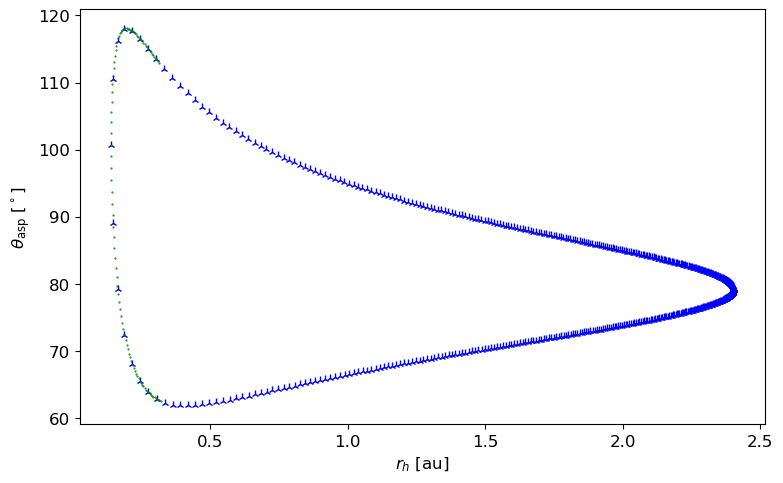

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), sharex=True, sharey=True, gridspec_kw=None)

ax.plot(eph_long["r"], eph_long["theta_asp"], 'b2')
ax.plot(eph_peri["r"], eph_peri["theta_asp"], 'g.', ms=1)
ax.set(xlabel=r"$r_h$ [au]", ylabel=r"$\theta_\mathrm{asp}$ $[^\circ]$")


plt.tight_layout()
plt.show();

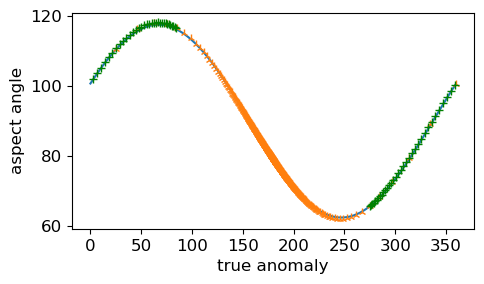

[-27.56043161  89.87385886 -23.16085143]


In [9]:
from scipy.optimize import curve_fit
def cos(x, a, b, phase):
    return a * np.cos(np.deg2rad(x) + phase) + b

popt, _ = curve_fit(cos, eph_long["true_anom"], eph_long["theta_asp"])
xx = np.arange(0, 360)

fig, axs = plt.subplots(1, 1, figsize=(5, 3), sharex=False, sharey=False, gridspec_kw=None)
axs.plot(xx, cos(xx, *popt))
axs.set(xlabel="true anomaly", ylabel="aspect angle")
axs.plot(eph_long["true_anom"], eph_long["theta_asp"], '2')
axs.plot(eph_peri["true_anom"], eph_peri["theta_asp"], 'g+')
plt.tight_layout()
plt.show();
print(popt)

Just by chance, aspect angle is nearly a sinusoidal function of true anomaly for phaethon. Actually they are related with certain combination of trigonometric functions, 
$$ \cos \theta_\mathrm{asp} = - \cos f + (\tan \beta_p + |\tan \beta_s|) \sin \beta $$
where subscripts s and p means spin and perihelrion of Phaethon.

The aspect angle is the angle between the north pole (spin vector) and the asteroid-Sun vector. What we have from the ephemerides are the **heliocentric** ecliptic coordinates, which give the Sun-asteroid vector. Although we can change it to the ecliptic coordinate of the Sun viewed from the asteroid, I want to use the geometrical identity that the aspect angle is identical to the angle between the Sun-asteroid vector and the south pole (negative of the spin vector). From the figure below, the distance between the red points and the ``-Spin`` (the south pole) is the aspect angle. You now can understand why the aspect angle increases near the perihelion. Note that because of the sphericity of the celestial sphere, the actual angular distance is not as large as you see in this 2D planar plot.

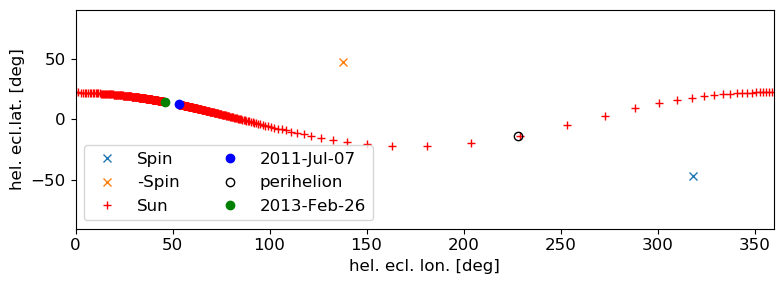

In [10]:
xx = np.arange(0, 360)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)

lons = eph_long["EclLon"][80:-80]
lats = eph_long["EclLat"][80:-80]
southpole = [phys["spin_ecl_lon"] - 180 * u.deg, -1 * phys["spin_ecl_lat"]]
coslat = np.cos(np.deg2rad(lats))

ax.plot(phys["spin_ecl_lon"], phys["spin_ecl_lat"], 'x', label="Spin")
ax.plot(southpole[0], southpole[1], 'x', label="-Spin")
ax.set(xlim=(0, 360), ylim=(-90, 90), xlabel="hel. ecl. lon. [deg]", ylabel='hel. ecl.lat. [deg]')


i_peri = len(eph_peri)//2
ax.plot(lons, lats, 'r+', label="Sun")
ax.plot(lons[0], lats[0], 'bo', label=eph_long["datetime_str"][0][:11])
ax.plot(eph_peri["EclLon"][i_peri], eph_peri["EclLat"][i_peri], 'ko', mfc='none', label="perihelion")
ax.plot(lons[-1], lats[-1], 'go', label=eph_long["datetime_str"][-1][:11])
ax.legend(loc=3, ncol=2)

plt.tight_layout()
plt.show();


A slightly better way to present, with cosine latitude multiplied to the x-axis:
```python
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharey=ax1)

lons = eph_long["EclLon"][80:-80]
lats = eph_long["EclLat"][80:-80]
southpole = [phys["spin_ecl_lon"] - 180 * u.deg, -1 * phys["spin_ecl_lat"]]
coslat = np.cos(np.deg2rad(lats))

ax1.plot(phys["spin_ecl_lon"], phys["spin_ecl_lat"], 'x', label="Spin")
ax1.plot(southpole[0], southpole[1], 'x', label="-Spin")
ax1.set(xlim=(0, 360), ylim=(-90, 90), xlabel="hel. ecl. lon. [deg]", ylabel='hel. ecl.lat. [deg]')

ax2.plot(phys["spin_ecl_lon"] * np.cos(np.deg2rad(phys["spin_ecl_lat"])), phys["spin_ecl_lat"], 'x', label="Spin")
ax2.plot(southpole[0] * np.cos(np.deg2rad(southpole[1])), southpole[1], 'x', label="-Spin")
ax2.set(xlim=(0, 360), ylim=(-90, 90),
        xlabel="hel. ecl. lon. * cos(hel. ecl. lat.) [deg]")

for ax, factor in zip([ax1, ax2], [np.ones_like(lons), coslat]):
    i_peri = len(lons)//2
    ax.plot(lons * factor, lats, 'r+', label="Sun")
    ax.plot(lons[0] * factor[0], lats[0], 'bo', label=eph_long["datetime_str"][0][:11])
    ax.plot(lons[i_peri] * factor[i_peri], lats[i_peri], 'kx', label="perihelion")
    ax.plot(lons[-1] * factor[-1], lats[-1], 'go', label=eph_long["datetime_str"][-1][:11])
    ax.legend(loc=3, ncol=2)

plt.tight_layout()
plt.show()
```